# Machine Learning Training and Validation for Stress Detection

This notebook implements comprehensive machine learning training and validation for multi-class stress detection using physiological signals from smartwatch data.

## Dataset
- **Source**: Cleaned multi-dataset combination (WESAD, EPM-E4, Wearable)
- **Samples**: 10,387 samples × 109 physiological features
- **Classes**: baseline, stress, happiness, aerobic, anaerobic, anger
- **Subjects**: 49 subjects

## Objectives
1. Train multiple ML models for stress classification
2. Implement proper validation techniques
3. Perform hyperparameter optimization
4. Analyze feature importance
5. Generate comprehensive evaluation metrics

In [7]:
# =============================================================================
# SECTION 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
import warnings
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, 
    StratifiedKFold, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Additional ML libraries
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available - will skip XGBoost models")

# Import KNN Imputer for advanced missing data imputation
from sklearn.impute import KNNImputer

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("="*80)
print("MACHINE LEARNING TRAINING AND VALIDATION NOTEBOOK")
print("="*80)
print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

MACHINE LEARNING TRAINING AND VALIDATION NOTEBOOK
Libraries imported successfully!
XGBoost available: True
Timestamp: 2026-02-01 10:58:53


In [ ]:
# =============================================================================
# SECTION 2: LOAD AND PREPARE DATASET
# =============================================================================

# Define paths
BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
DATA_PATH = BASE_PATH / 'data' / 'unified'
RESULTS_PATH = BASE_PATH / 'results'
MODELS_PATH = BASE_PATH / 'models' / 'trained_models'

# Create directories
RESULTS_PATH.mkdir(exist_ok=True)
MODELS_PATH.mkdir(exist_ok=True)

# Load the cleaned dataset
dataset_path = DATA_PATH / 'cleaned_classification_dataset.csv'
print("="*60)
print("LOADING AND PREPARING DATASET")
print("="*60)

try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset loaded successfully from: {dataset_path}")
    print(f"  Dataset shape: {df.shape}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print(f"Dataset not found at: {dataset_path}")
    print("Please ensure the data processing pipeline has been completed.")
    raise

# Dataset overview
print(f"\nDataset Overview:")
print(f"  Total samples: {len(df):,}")
print(f"  Total features: {df.shape[1]}")
print(f"  Subjects: {df['subject_id'].nunique() if 'subject_id' in df.columns else 'Unknown'}")

# Check for classification labels
if 'classification_label' in df.columns:
    label_counts = df['classification_label'].value_counts()
    print(f"\nClassification Label Distribution:")
    for label, count in label_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {label}: {count:,} samples ({percentage:.1f}%)")
else:
    print("No 'classification_label' column found!")
    
# Check missing values
missing_summary = df.isnull().sum()
total_missing = missing_summary.sum()
missing_percentage = (total_missing / (df.shape[0] * df.shape[1])) * 100

print(f"\nData Quality:")
print(f"  Missing values: {total_missing:,} ({missing_percentage:.1f}%)")
print(f"  Complete cases: {df.dropna().shape[0]:,}")

if missing_percentage > 0:
    print(f"  Columns with missing values: {(missing_summary > 0).sum()}")
    if (missing_summary > 0).sum() <= 10:
        high_missing = missing_summary[missing_summary > 0].sort_values(ascending=False)
        for col, missing in high_missing.items():
            pct = (missing / len(df)) * 100
            print(f"    {col}: {missing:,} ({pct:.1f}%)")

# Show sample of data
print(f"\nDataset Sample (first 3 rows, first 8 columns):")
print(df.iloc[:3, :8].to_string())

print(f"\nColumn Types:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"  Numeric columns: {len(numeric_cols)}")
print(f"  Categorical columns: {len(categorical_cols)}")
if categorical_cols:
    print(f"  Categorical: {categorical_cols}")

print("Dataset loaded and analyzed successfully!")

LOADING AND PREPARING DATASET
✓ Dataset loaded successfully from: /home/alvaro-ibarra/smartwatch-stress-detection/data/unified/cleaned_classification_dataset.csv
  Dataset shape: (10387, 116)
  Memory usage: 11.28 MB

Dataset Overview:
  Total samples: 10,387
  Total features: 116
  Subjects: 49

Classification Label Distribution:
  baseline: 5,563 samples (53.6%)
  stress: 3,888 samples (37.4%)
  happiness: 391 samples (3.8%)
  aerobic: 335 samples (3.2%)
  anaerobic: 185 samples (1.8%)
  anger: 25 samples (0.2%)

Data Quality:
  Missing values: 360,328 (29.9%)
  Complete cases: 6,683
  Columns with missing values: 108

Dataset Sample (first 3 rows, first 8 columns):
   subject_id  stress_label  original_label  eda_us  temp_c    acc_x_g    acc_y_g    acc_z_g
0  subject_23           NaN               0     NaN     NaN  30.319792 -30.285417  17.737500
1  subject_23           NaN               0     NaN     NaN  25.193750 -20.998958  20.176042
2  subject_23           NaN               0 

In [ ]:
# =============================================================================
# SECTION 3: SPLIT DATA INTO TRAINING AND VALIDATION SETS
# =============================================================================

print("="*60)
print("PREPARING DATA FOR TRAINING")
print("="*60)

# Identify feature columns (exclude metadata)
metadata_cols = ['subject_id', 'original_label', 'window_id', 'original_row_index', 
                'dataset', 'category', 'classification_label']
feature_cols = [col for col in df.columns if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]

print(f"Feature Engineering:")
print(f"  Total columns: {df.shape[1]}")
print(f"  Feature columns: {len(feature_cols)}")
print(f"  Metadata columns: {len(metadata_cols)}")

# Prepare features and labels
X = df[feature_cols].copy()
y = df['classification_label'].copy()

print(f"  Feature matrix shape: {X.shape}")
print(f"  Label distribution: {y.value_counts().to_dict()}")

# Handle missing values in features using KNN Imputation
missing_before = X.isnull().sum().sum()
if missing_before > 0:
    print(f"  Missing values before imputation: {missing_before:,}")
    
    # Advanced KNN imputation for better data quality
    print(f"  Applying KNN imputation for missing data...")
    print(f"  This creates a fully rich dataset by using relationships between features")
    
    # Use KNN Imputer with optimal parameters for physiological data
    knn_imputer = KNNImputer(
        n_neighbors=5,  # Use 5 nearest neighbors
        weights='uniform',  # Equal weight to all neighbors
        metric='nan_euclidean'  # Handle NaN values properly
    )
    
    # Apply KNN imputation
    X_imputed = knn_imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
    
    missing_after = X.isnull().sum().sum()
    print(f"  Missing values after KNN imputation: {missing_after:,}")
    
    # Show imputation quality statistics
    if missing_before > 0:
        imputation_rate = ((missing_before - missing_after) / missing_before) * 100
        print(f"  Imputation success rate: {imputation_rate:.1f}%")
        print(f"  KNN imputation creates fully connected feature relationships")
        print(f"  Each missing value filled using {5} most similar samples")
    
    # Save the imputer for future use
    imputer_path = MODELS_PATH / 'knn_imputer.pkl'
    with open(imputer_path, 'wb') as f:
        pickle.dump(knn_imputer, f)
    print(f"  KNN imputer saved to: {imputer_path}")
    
else:
    print(f"  No missing values detected - dataset already complete!")
    knn_imputer = None

# Remove any rows with missing labels
if y.isnull().sum() > 0:
    print(f"  Removing {y.isnull().sum()} rows with missing labels")
    mask = ~y.isnull()
    X = X[mask]
    y = y[mask]

# Encode labels if they are strings
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"\nLabel Encoding:")
for original, encoded in label_mapping.items():
    print(f"  {original} -> {encoded}")

# Subject-aware train-test split (ensure subjects are not split across train/test)
if 'subject_id' in df.columns:
    subjects = df.loc[X.index, 'subject_id'].values
    
    # Handle missing subject_id values
    valid_subject_mask = pd.notna(subjects)
    if not valid_subject_mask.all():
        print(f"  Warning: {(~valid_subject_mask).sum()} samples have missing subject_id, removing them")
        # Filter out samples with missing subject_id
        X = X[valid_subject_mask]
        y_encoded = y_encoded[valid_subject_mask]
        subjects = subjects[valid_subject_mask]
    
    unique_subjects = np.unique(subjects)
    
    # Split subjects into train/test (80/20 split)
    train_subjects, test_subjects = train_test_split(
        unique_subjects, test_size=0.2, random_state=42, shuffle=True
    )
    
    # Create train/test masks based on subjects
    train_mask = np.isin(subjects, train_subjects)
    test_mask = np.isin(subjects, test_subjects)
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y_encoded[train_mask]
    y_test = y_encoded[test_mask]
    
    print(f"\nSubject-aware data split:")
    print(f"  Training subjects: {len(train_subjects)} ({len(train_subjects)/len(unique_subjects)*100:.1f}%)")
    print(f"  Testing subjects: {len(test_subjects)} ({len(test_subjects)/len(unique_subjects)*100:.1f}%)")
    print(f"  Training samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Testing samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

else:
    # Standard train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, 
        stratify=y_encoded, shuffle=True
    )
    print(f"\nStandard stratified data split:")
    print(f"  Training samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Testing samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Check label distribution in splits
print(f"\nLabel distribution in training set:")
train_labels, train_counts = np.unique(y_train, return_counts=True)
for label_idx, count in zip(train_labels, train_counts):
    original_label = le.inverse_transform([label_idx])[0]
    print(f"  {original_label}: {count:,} ({count/len(y_train)*100:.1f}%)")

print(f"\nLabel distribution in test set:")
test_labels, test_counts = np.unique(y_test, return_counts=True)
for label_idx, count in zip(test_labels, test_counts):
    original_label = le.inverse_transform([label_idx])[0]
    print(f"  {original_label}: {count:,} ({count/len(y_test)*100:.1f}%)")

# Feature scaling
print(f"\nFeature Scaling:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Training features scaled: {X_train_scaled.shape}")
print(f"  Test features scaled: {X_test_scaled.shape}")
print(f"  Scaler fitted on training data only")

# Save preprocessing objects (including KNN imputer)
preprocessing_objects = {
    'label_encoder': le,
    'feature_scaler': scaler,
    'knn_imputer': knn_imputer,
    'feature_columns': feature_cols,
    'label_mapping': label_mapping
}

preprocessing_path = MODELS_PATH / 'preprocessing_objects.pkl'
with open(preprocessing_path, 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print(f"  Preprocessing objects saved to: {preprocessing_path}")
print("Data preparation completed successfully!")

PREPARING DATA FOR TRAINING
Feature Engineering:
  Total columns: 116
  Feature columns: 109
  Metadata columns: 7
  Feature matrix shape: (10387, 109)
  Label distribution: {'baseline': 5563, 'stress': 3888, 'happiness': 391, 'aerobic': 335, 'anaerobic': 185, 'anger': 25}
  Missing values before imputation: 352,705
  Applying KNN imputation for missing data...
  This creates a fully rich dataset by using relationships between features
  Missing values after KNN imputation: 0
  Imputation success rate: 100.0%
  KNN imputation creates fully connected feature relationships
  Each missing value filled using 5 most similar samples
  KNN imputer saved to: /home/alvaro-ibarra/smartwatch-stress-detection/models/trained_models/knn_imputer.pkl

Label Encoding:
  aerobic -> 0
  anaerobic -> 1
  anger -> 2
  baseline -> 3
  happiness -> 4
  stress -> 5

Subject-aware data split:
  Training subjects: 39 (79.6%)
  Testing subjects: 10 (20.4%)
  Training samples: 7,474 (76.5%)
  Testing samples: 2,2

In [ ]:
# =============================================================================
# SECTION 3.1: DATA QUALITY ANALYSIS AFTER KNN IMPUTATION
# =============================================================================

print("="*60)
print("ANALYZING DATA QUALITY AFTER KNN IMPUTATION")
print("="*60)

# Analyze the fully rich dataset after KNN imputation
print("Dataset Quality Analysis:")
print(f"  Total samples: {len(X):,}")
print(f"  Total features: {X.shape[1]}")
print(f"  Complete samples: {(X.isnull().sum(axis=1) == 0).sum():,}")
print(f"  Data completeness: {((X.isnull().sum(axis=1) == 0).sum() / len(X)) * 100:.1f}%")

# Subject-level completeness analysis
if 'subject_id' in df.columns:
    subject_completeness = []
    unique_subjects = df.loc[X.index, 'subject_id'].unique()
    
    print(f"\nSubject-level Analysis:")
    print(f"  Total subjects: {len(unique_subjects)}")
    
    complete_subjects = 0
    for subject in unique_subjects:
        subject_mask = df.loc[X.index, 'subject_id'] == subject
        subject_data = X[subject_mask]
        
        # Check completeness for this subject
        subject_missing = subject_data.isnull().sum().sum()
        subject_total = subject_data.shape[0] * subject_data.shape[1]
        subject_completeness_pct = ((subject_total - subject_missing) / subject_total) * 100
        
        subject_completeness.append(subject_completeness_pct)
        if subject_completeness_pct >= 99.0:
            complete_subjects += 1
    
    print(f"  Subjects with ≥99% complete data: {complete_subjects}/{len(unique_subjects)} ({(complete_subjects/len(unique_subjects))*100:.1f}%)")
    print(f"  Average subject completeness: {np.mean(subject_completeness):.1f}%")
    print(f"  Min subject completeness: {np.min(subject_completeness):.1f}%")
    print(f"  Max subject completeness: {np.max(subject_completeness):.1f}%")

# Class distribution analysis with complete data
print(f"\nClass Distribution (Fully Rich Dataset):")
class_counts = y.value_counts()
for class_name, count in class_counts.items():
    percentage = (count / len(y)) * 100
    print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")

# Feature-level analysis
print(f"\nFeature Quality Analysis:")
feature_stats = []
for col in X.columns:
    feature_stats.append({
        'feature': col,
        'missing': X[col].isnull().sum(),
        'unique_values': X[col].nunique(),
        'mean': X[col].mean() if pd.api.types.is_numeric_dtype(X[col]) else None,
        'std': X[col].std() if pd.api.types.is_numeric_dtype(X[col]) else None
    })

# Show features with highest variability (good for classification)
if feature_stats:
    numeric_features = [f for f in feature_stats if f['std'] is not None]
    high_variance_features = sorted(numeric_features, key=lambda x: x['std'], reverse=True)[:10]
    
    print(f"  Top 10 most variable features (good for classification):")
    for i, feature in enumerate(high_variance_features, 1):
        print(f"    {i}. {feature['feature']}: std={feature['std']:.4f}, mean={feature['mean']:.4f}")

# Correlation analysis for key physiological signals
key_signals = ['eda_us', 'temp_c', 'acc_x_g', 'acc_y_g', 'acc_z_g', 'hr_bpm', 'bvp']
available_signals = [col for col in key_signals if col in X.columns]

if len(available_signals) >= 2:
    print(f"\nKey Physiological Signals Correlation:")
    correlation_matrix = X[available_signals].corr()
    print("  Strong correlations (|r| > 0.7):")
    
    strong_correlations = []
    for i in range(len(available_signals)):
        for j in range(i+1, len(available_signals)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                strong_correlations.append((available_signals[i], available_signals[j], corr_val))
    
    if strong_correlations:
        for signal1, signal2, corr in strong_correlations:
            print(f"    {signal1} ↔ {signal2}: r={corr:.3f}")
    else:
        print("    No strong correlations detected (good for model diversity)")

print(f"\n✅ Data Quality Summary:")
print(f"   • Dataset is now fully rich with KNN imputation")
print(f"   • Ready for comprehensive subject classification")
print(f"   • All {len(unique_subjects)} subjects have complete feature profiles")
print(f"   • {X.shape[1]} physiological features available for training")
print(f"   • {len(class_counts)} classification targets: {list(class_counts.keys())}")

print("Data quality analysis completed successfully!")

ANALYZING DATA QUALITY AFTER KNN IMPUTATION
Dataset Quality Analysis:
  Total samples: 9,772
  Total features: 109
  Complete samples: 9,772
  Data completeness: 100.0%

Subject-level Analysis:
  Total subjects: 49
  Subjects with ≥99% complete data: 49/49 (100.0%)
  Average subject completeness: 100.0%
  Min subject completeness: 100.0%
  Max subject completeness: 100.0%

Class Distribution (Fully Rich Dataset):
  baseline: 5,563 samples (53.6%)
  stress: 3,888 samples (37.4%)
  happiness: 391 samples (3.8%)
  aerobic: 335 samples (3.2%)
  anaerobic: 185 samples (1.8%)
  anger: 25 samples (0.2%)

Feature Quality Analysis:
  Top 10 most variable features (good for classification):
    1. BVP_energy: std=11871889.2421, mean=7985232.1891
    2. ACC_Z_energy: std=1528183.1590, mean=2119383.2449
    3. ACC_X_energy: std=982908.2003, mean=1215545.3297
    4. ACC_Y_energy: std=712045.2162, mean=695073.1409
    5. TEMP_energy: std=599460.3402, mean=209738.9867
    6. HR_energy: std=140244.251

In [ ]:
# =============================================================================
# SECTION 4: DEFINE MODEL ARCHITECTURES
# =============================================================================

print("="*60)
print("DEFINING MODEL ARCHITECTURES")
print("="*60)

# Define base models with initial hyperparameters
models = {
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        ),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    
    'Support Vector Machine': {
        'model': SVC(
            C=1.0,
            kernel='rbf',
            gamma='scale',
            random_state=42,
            probability=True  # Enable probability estimates
        ),
        'param_grid': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.01, 0.1]
        }
    },
    
    'Logistic Regression': {
        'model': LogisticRegression(
            random_state=42,
            max_iter=1000,
            multi_class='ovr'
        ),
        'param_grid': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(
            n_neighbors=5,
            weights='uniform'
        ),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    
    'Gaussian Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        }
    }
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = {
        'model': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            eval_metric='mlogloss'
        ),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    }

print(f"Defined {len(models)} machine learning models:")
for i, (name, config) in enumerate(models.items(), 1):
    model = config['model']
    param_count = len(config['param_grid'])
    print(f"  {i}. {name}")
    print(f"     Model: {type(model).__name__}")
    print(f"     Hyperparameters to tune: {param_count}")
    print(f"     Parameters: {list(config['param_grid'].keys())}")

# Cross-validation setup
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\nCross-validation setup:")
print(f"  Strategy: {cv_folds}-fold Stratified K-Fold")
print(f"  Ensures balanced class distribution in each fold")
print(f"  Random state: 42 (reproducible results)")

# Evaluation metrics
evaluation_metrics = [
    'accuracy',
    'precision_macro',
    'recall_macro', 
    'f1_macro',
    'f1_weighted'
]

print(f"\nEvaluation metrics:")
for metric in evaluation_metrics:
    print(f"  - {metric}")

print("Model architectures defined successfully!")

DEFINING MODEL ARCHITECTURES
Defined 7 machine learning models:
  1. Random Forest
     Model: RandomForestClassifier
     Hyperparameters to tune: 4
     Parameters: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
  2. Gradient Boosting
     Model: GradientBoostingClassifier
     Hyperparameters to tune: 4
     Parameters: ['n_estimators', 'learning_rate', 'max_depth', 'subsample']
  3. Support Vector Machine
     Model: SVC
     Hyperparameters to tune: 3
     Parameters: ['C', 'kernel', 'gamma']
  4. Logistic Regression
     Model: LogisticRegression
     Hyperparameters to tune: 3
     Parameters: ['C', 'penalty', 'solver']
  5. K-Nearest Neighbors
     Model: KNeighborsClassifier
     Hyperparameters to tune: 3
     Parameters: ['n_neighbors', 'weights', 'metric']
  6. Gaussian Naive Bayes
     Model: GaussianNB
     Hyperparameters to tune: 1
     Parameters: ['var_smoothing']
  7. XGBoost
     Model: XGBClassifier
     Hyperparameters to tune: 4
     Param

In [ ]:
# =============================================================================
# SECTION 5: SET UP TRAINING CONFIGURATION
# =============================================================================

print("="*60)
print("SETTING UP TRAINING CONFIGURATION")
print("="*60)

# Training configuration
training_config = {
    'cross_validation': {
        'folds': cv_folds,
        'strategy': 'StratifiedKFold',
        'random_state': 42,
        'scoring_metrics': evaluation_metrics
    },
    
    'hyperparameter_tuning': {
        'method': 'GridSearchCV',
        'scoring': 'f1_macro',  # Primary metric for optimization
        'cv_folds': 3,  # Reduced for faster tuning
        'n_jobs': -1,   # Use all available cores
        'verbose': 1    # Show progress
    },
    
    'model_selection': {
        'best_model_metric': 'f1_macro',
        'save_all_models': True,
        'save_best_model_only': False
    },
    
    'feature_importance': {
        'analyze': True,
        'top_features': 20,
        'plot_importance': True
    },
    
    'validation': {
        'holdout_test': True,
        'cross_validation': True,
        'learning_curves': True
    }
}

print("Training Configuration:")
print("━" * 40)

print("Cross-Validation:")
print(f"  Strategy: {training_config['cross_validation']['strategy']}")
print(f"  Folds: {training_config['cross_validation']['folds']}")
print(f"  Metrics: {', '.join(training_config['cross_validation']['scoring_metrics'])}")

print("\nHyperparameter Tuning:")
print(f"  Method: {training_config['hyperparameter_tuning']['method']}")
print(f"  Primary scoring metric: {training_config['hyperparameter_tuning']['scoring']}")
print(f"  CV folds for tuning: {training_config['hyperparameter_tuning']['cv_folds']}")
print(f"  Parallel jobs: {training_config['hyperparameter_tuning']['n_jobs']}")

print("\nModel Selection:")
print(f"  Selection metric: {training_config['model_selection']['best_model_metric']}")
print(f"  Save all models: {training_config['model_selection']['save_all_models']}")

print("\nFeature Analysis:")
print(f"  Analyze importance: {training_config['feature_importance']['analyze']}")
print(f"  Top features to show: {training_config['feature_importance']['top_features']}")

print("\nValidation Strategy:")
print(f"  Holdout test set: {training_config['validation']['holdout_test']}")
print(f"  Cross-validation: {training_config['validation']['cross_validation']}")
print(f"  Learning curves: {training_config['validation']['learning_curves']}")

# Results storage setup
results = {
    'training_config': training_config,
    'models': {},
    'best_models': {},
    'evaluation_metrics': {},
    'feature_importance': {},
    'training_history': {},
    'timestamp': datetime.now().isoformat()
}

print(f"\nResults Storage:")
print(f"  Models directory: {MODELS_PATH}")
print(f"  Results directory: {RESULTS_PATH}")
print(f"  Timestamp: {results['timestamp']}")

# Create subdirectories for organized storage
model_subdirs = ['base_models', 'tuned_models', 'best_model']
for subdir in model_subdirs:
    (MODELS_PATH / subdir).mkdir(exist_ok=True)

results_subdirs = ['metrics', 'plots', 'reports']
for subdir in results_subdirs:
    (RESULTS_PATH / subdir).mkdir(exist_ok=True)

print(f"  Created subdirectories for organized storage")

# Performance tracking setup
performance_tracker = {
    'training_times': {},
    'prediction_times': {},
    'memory_usage': {},
    'convergence_info': {}
}

print("Training configuration completed!")
print("Ready to begin model training and validation")

SETTING UP TRAINING CONFIGURATION
Training Configuration:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-Validation:
  Strategy: StratifiedKFold
  Folds: 5
  Metrics: accuracy, precision_macro, recall_macro, f1_macro, f1_weighted

Hyperparameter Tuning:
  Method: GridSearchCV
  Primary scoring metric: f1_macro
  CV folds for tuning: 3
  Parallel jobs: -1

Model Selection:
  Selection metric: f1_macro
  Save all models: True

Feature Analysis:
  Analyze importance: True
  Top features to show: 20

Validation Strategy:
  Holdout test set: True
  Cross-validation: True
  Learning curves: True

Results Storage:
  Models directory: /home/alvaro-ibarra/smartwatch-stress-detection/models/trained_models
  Results directory: /home/alvaro-ibarra/smartwatch-stress-detection/results
  Timestamp: 2026-02-01T10:59:07.319886
  Created subdirectories for organized storage
✓ Training configuration completed!
✓ Ready to begin model training and validation


In [10]:
# =============================================================================
# SECTION 6: TRAIN THE MODELS
# =============================================================================

print("="*80)
print("MODEL TRAINING AND HYPERPARAMETER OPTIMIZATION")
print("="*80)

import time
from sklearn.model_selection import GridSearchCV

# Train each model with hyperparameter tuning
trained_models = {}
training_results = {}

for model_name, model_config in models.items():
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name.upper()}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    try:
        # Set up GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['param_grid'],
            cv=training_config['hyperparameter_tuning']['cv_folds'],
            scoring=training_config['hyperparameter_tuning']['scoring'],
            n_jobs=training_config['hyperparameter_tuning']['n_jobs'],
            verbose=training_config['hyperparameter_tuning']['verbose'],
            return_train_score=True
        )
        
        print(f"Performing hyperparameter optimization...")
        print(f"  Parameter combinations: {len(grid_search.param_grid) if isinstance(grid_search.param_grid, list) else np.prod([len(v) for v in grid_search.param_grid.values()])}")
        print(f"  CV folds: {training_config['hyperparameter_tuning']['cv_folds']}")
        print(f"  Scoring metric: {training_config['hyperparameter_tuning']['scoring']}")
        
        # Fit the grid search
        grid_search.fit(X_train_scaled, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        
        # Calculate training time
        training_time = time.time() - start_time
        
        # Store results
        trained_models[model_name] = {
            'grid_search': grid_search,
            'best_model': best_model,
            'best_score': best_score,
            'best_params': best_params,
            'training_time': training_time
        }
        
        # Training results summary
        training_results[model_name] = {
            'best_cv_score': best_score,
            'best_parameters': best_params,
            'training_time_seconds': training_time,
            'n_parameter_combinations': len(grid_search.cv_results_['params']),
            'cv_results': grid_search.cv_results_
        }
        
        print(f"✓ Training completed successfully!")
        print(f"  Best CV Score ({training_config['hyperparameter_tuning']['scoring']}): {best_score:.4f}")
        print(f"  Training Time: {training_time:.2f} seconds")
        print(f"  Best Parameters:")
        for param, value in best_params.items():
            print(f"    {param}: {value}")
            
        # Save the best model
        model_path = MODELS_PATH / 'tuned_models' / f'{model_name.lower().replace(" ", "_")}_best.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(best_model, f)
        print(f"  Model saved to: {model_path}")
        
    except Exception as e:
        print(f"❌ Training failed for {model_name}: {str(e)}")
        training_results[model_name] = {
            'error': str(e),
            'training_time_seconds': time.time() - start_time
        }

# Training summary
print(f"\n{'='*80}")
print("TRAINING SUMMARY")
print(f"{'='*80}")

successful_models = [name for name in trained_models.keys()]
failed_models = [name for name in models.keys() if name not in trained_models]

print(f"Successfully trained models: {len(successful_models)}")
print(f"Failed models: {len(failed_models)}")

if successful_models:
    print(f"\nModel Performance Summary (CV {training_config['hyperparameter_tuning']['scoring']}):")
    sorted_models = sorted(successful_models, 
                          key=lambda x: trained_models[x]['best_score'], 
                          reverse=True)
    
    for i, model_name in enumerate(sorted_models, 1):
        score = trained_models[model_name]['best_score']
        time_taken = trained_models[model_name]['training_time']
        print(f"  {i}. {model_name}: {score:.4f} ({time_taken:.1f}s)")

if failed_models:
    print(f"\nFailed models:")
    for model_name in failed_models:
        error = training_results[model_name].get('error', 'Unknown error')
        print(f"  - {model_name}: {error}")

# Save training results
training_results_path = RESULTS_PATH / 'training_results.json'
with open(training_results_path, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_results = {}
    for model_name, results in training_results.items():
        serializable_results[model_name] = {}
        for key, value in results.items():
            if key == 'cv_results':
                # Skip cv_results as it's too large and complex for JSON
                continue
            elif isinstance(value, (np.int64, np.int32)):
                serializable_results[model_name][key] = int(value)
            elif isinstance(value, (np.float64, np.float32)):
                serializable_results[model_name][key] = float(value)
            else:
                serializable_results[model_name][key] = value
    
    json.dump(serializable_results, f, indent=2)

print(f"\n✓ Training results saved to: {training_results_path}")
print(f"✓ All model training completed!")

# Store results for next sections
results['training_results'] = training_results
results['trained_models'] = list(trained_models.keys())

MODEL TRAINING AND HYPERPARAMETER OPTIMIZATION

TRAINING: RANDOM FOREST
Performing hyperparameter optimization...
  Parameter combinations: 108
  CV folds: 3
  Scoring metric: f1_macro
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✓ Training completed successfully!
  Best CV Score (f1_macro): 0.5262
  Training Time: 69.92 seconds
  Best Parameters:
    max_depth: None
    min_samples_leaf: 4
    min_samples_split: 10
    n_estimators: 200
  Model saved to: /home/alvaro-ibarra/smartwatch-stress-detection/models/trained_models/tuned_models/random_forest_best.pkl

TRAINING: GRADIENT BOOSTING
Performing hyperparameter optimization...
  Parameter combinations: 81
  CV folds: 3
  Scoring metric: f1_macro
Fitting 3 folds for each of 81 candidates, totalling 243 fits
✓ Training completed successfully!
  Best CV Score (f1_macro): 0.5153
  Training Time: 2339.08 seconds
  Best Parameters:
    learning_rate: 0.05
    max_depth: 5
    n_estimators: 150
    subsample: 1.0
  Model s

/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have insta

✓ Training completed successfully!
  Best CV Score (f1_macro): 0.5350
  Training Time: 79.79 seconds
  Best Parameters:
    learning_rate: 0.2
    max_depth: 5
    n_estimators: 50
    subsample: 0.8
  Model saved to: /home/alvaro-ibarra/smartwatch-stress-detection/models/trained_models/tuned_models/xgboost_best.pkl

TRAINING SUMMARY
Successfully trained models: 7
Failed models: 0

Model Performance Summary (CV f1_macro):
  1. XGBoost: 0.5350 (79.8s)
  2. Random Forest: 0.5262 (69.9s)
  3. Support Vector Machine: 0.5248 (246.4s)
  4. Gradient Boosting: 0.5153 (2339.1s)
  5. Gaussian Naive Bayes: 0.4716 (0.3s)
  6. Logistic Regression: 0.4539 (1063.9s)
  7. K-Nearest Neighbors: 0.4162 (9.9s)

✓ Training results saved to: /home/alvaro-ibarra/smartwatch-stress-detection/results/training_results.json
✓ All model training completed!


In [11]:
# =============================================================================
# SECTION 7: EVALUATE MODEL PERFORMANCE
# =============================================================================

print("="*80)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*80)

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_fscore_support, accuracy_score
)

# Comprehensive evaluation for each trained model
evaluation_results = {}

for model_name in trained_models.keys():
    print(f"\n{'='*60}")
    print(f"EVALUATING: {model_name.upper()}")
    print(f"{'='*60}")
    
    best_model = trained_models[model_name]['best_model']
    
    # Predictions on training set
    train_pred = best_model.predict(X_train_scaled)
    train_pred_proba = best_model.predict_proba(X_train_scaled) if hasattr(best_model, 'predict_proba') else None
    
    # Predictions on test set
    test_pred = best_model.predict(X_test_scaled)
    test_pred_proba = best_model.predict_proba(X_test_scaled) if hasattr(best_model, 'predict_proba') else None
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Detailed classification metrics
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, train_pred, average=None)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average=None)
    
    # Macro averages
    train_precision_macro = np.mean(train_precision)
    train_recall_macro = np.mean(train_recall)
    train_f1_macro = np.mean(train_f1)
    
    test_precision_macro = np.mean(test_precision)
    test_recall_macro = np.mean(test_recall)
    test_f1_macro = np.mean(test_f1)
    
    # Store evaluation results
    evaluation_results[model_name] = {
        'training': {
            'accuracy': train_accuracy,
            'precision_macro': train_precision_macro,
            'recall_macro': train_recall_macro,
            'f1_macro': train_f1_macro,
            'precision_per_class': train_precision.tolist(),
            'recall_per_class': train_recall.tolist(),
            'f1_per_class': train_f1.tolist()
        },
        'testing': {
            'accuracy': test_accuracy,
            'precision_macro': test_precision_macro,
            'recall_macro': test_recall_macro,
            'f1_macro': test_f1_macro,
            'precision_per_class': test_precision.tolist(),
            'recall_per_class': test_recall.tolist(),
            'f1_per_class': test_f1.tolist()
        },
        'confusion_matrix': {
            'training': confusion_matrix(y_train, train_pred).tolist(),
            'testing': confusion_matrix(y_test, test_pred).tolist()
        },
        'overfitting_analysis': {
            'accuracy_gap': train_accuracy - test_accuracy,
            'f1_gap': train_f1_macro - test_f1_macro,
            'is_overfitting': (train_accuracy - test_accuracy) > 0.1
        }
    }
    
    # Print performance summary
    print(f"Performance Summary:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Accuracy Gap: {train_accuracy - test_accuracy:.4f}")
    
    print(f"\n  Training F1-Macro: {train_f1_macro:.4f}")
    print(f"  Test F1-Macro: {test_f1_macro:.4f}")
    print(f"  F1 Gap: {train_f1_macro - test_f1_macro:.4f}")
    
    print(f"\n  Training Precision-Macro: {train_precision_macro:.4f}")
    print(f"  Test Precision-Macro: {test_precision_macro:.4f}")
    
    print(f"\n  Training Recall-Macro: {train_recall_macro:.4f}")
    print(f"  Test Recall-Macro: {test_recall_macro:.4f}")
    
    # Overfitting analysis
    if evaluation_results[model_name]['overfitting_analysis']['is_overfitting']:
        print(f"\n  ⚠️  Potential overfitting detected (accuracy gap > 0.1)")
    else:
        print(f"\n  ✓  No significant overfitting detected")
    
    # Per-class performance on test set
    print(f"\nPer-class Performance (Test Set):")
    class_names = le.classes_
    for i, class_name in enumerate(class_names):
        if i < len(test_precision):
            print(f"  {class_name}:")
            print(f"    Precision: {test_precision[i]:.4f}")
            print(f"    Recall: {test_recall[i]:.4f}")
            print(f"    F1-Score: {test_f1[i]:.4f}")
    
    # Classification report
    print(f"\nDetailed Classification Report (Test Set):")
    target_names = [le.classes_[i] for i in range(len(le.classes_))]
    print(classification_report(y_test, test_pred, target_names=target_names, digits=4))

# Overall performance comparison
print(f"\n{'='*80}")
print("OVERALL PERFORMANCE COMPARISON")
print(f"{'='*80}")

# Create performance comparison table
performance_comparison = []
for model_name in evaluation_results.keys():
    metrics = evaluation_results[model_name]
    performance_comparison.append({
        'Model': model_name,
        'Test_Accuracy': metrics['testing']['accuracy'],
        'Test_F1_Macro': metrics['testing']['f1_macro'],
        'Test_Precision_Macro': metrics['testing']['precision_macro'],
        'Test_Recall_Macro': metrics['testing']['recall_macro'],
        'Overfitting': metrics['overfitting_analysis']['is_overfitting'],
        'Accuracy_Gap': metrics['overfitting_analysis']['accuracy_gap'],
        'Training_Time': trained_models[model_name]['training_time']
    })

# Sort by test F1-macro score
performance_comparison.sort(key=lambda x: x['Test_F1_Macro'], reverse=True)

print(f"Model Performance Ranking (by Test F1-Macro):")
print("-" * 90)
print(f"{'Rank':<4} {'Model':<20} {'Accuracy':<10} {'F1-Macro':<10} {'Precision':<10} {'Recall':<10} {'Time(s)':<8}")
print("-" * 90)

for i, model_metrics in enumerate(performance_comparison, 1):
    print(f"{i:<4} {model_metrics['Model']:<20} "
          f"{model_metrics['Test_Accuracy']:<10.4f} "
          f"{model_metrics['Test_F1_Macro']:<10.4f} "
          f"{model_metrics['Test_Precision_Macro']:<10.4f} "
          f"{model_metrics['Test_Recall_Macro']:<10.4f} "
          f"{model_metrics['Training_Time']:<8.1f}")

# Identify best model
best_model_name = performance_comparison[0]['Model']
best_model_metrics = evaluation_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  Test Accuracy: {best_model_metrics['testing']['accuracy']:.4f}")
print(f"  Test F1-Macro: {best_model_metrics['testing']['f1_macro']:.4f}")
print(f"  Training Time: {trained_models[best_model_name]['training_time']:.2f} seconds")

# Save evaluation results
evaluation_path = RESULTS_PATH / 'model_evaluation_results.json'
with open(evaluation_path, 'w') as f:
    json.dump(evaluation_results, f, indent=2)

performance_comparison_path = RESULTS_PATH / 'performance_comparison.json'
with open(performance_comparison_path, 'w') as f:
    json.dump(performance_comparison, f, indent=2)

print(f"\n✓ Evaluation results saved to: {evaluation_path}")
print(f"✓ Performance comparison saved to: {performance_comparison_path}")

# Store results for visualization
results['evaluation_results'] = evaluation_results
results['performance_comparison'] = performance_comparison
results['best_model'] = best_model_name

COMPREHENSIVE MODEL EVALUATION

EVALUATING: RANDOM FOREST
Performance Summary:
  Training Accuracy: 0.9835
  Test Accuracy: 0.8990
  Accuracy Gap: 0.0845

  Training F1-Macro: 0.7880
  Test F1-Macro: 0.4608
  F1 Gap: 0.3272

  Training Precision-Macro: 0.8204
  Test Precision-Macro: 0.6042

  Training Recall-Macro: 0.7659
  Test Recall-Macro: 0.4215

  ✓  No significant overfitting detected

Per-class Performance (Test Set):
  aerobic:
    Precision: 0.9333
    Recall: 0.4118
    F1-Score: 0.5714
  anaerobic:
    Precision: 0.0000
    Recall: 0.0000
    F1-Score: 0.0000
  anger:
    Precision: 0.0000
    Recall: 0.0000
    F1-Score: 0.0000
  baseline:
    Precision: 0.8922
    Recall: 0.9660
    F1-Score: 0.9277
  happiness:
    Precision: 0.8889
    Recall: 0.2105
    F1-Score: 0.3404
  stress:
    Precision: 0.9107
    Recall: 0.9407
    F1-Score: 0.9255

Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

     aerobic     0.9333    0.411

COMPREHENSIVE VISUALIZATION OF RESULTS
✓ Comprehensive visualization saved to: /home/alvaro-ibarra/smartwatch-stress-detection/results/plots/comprehensive_model_evaluation.png


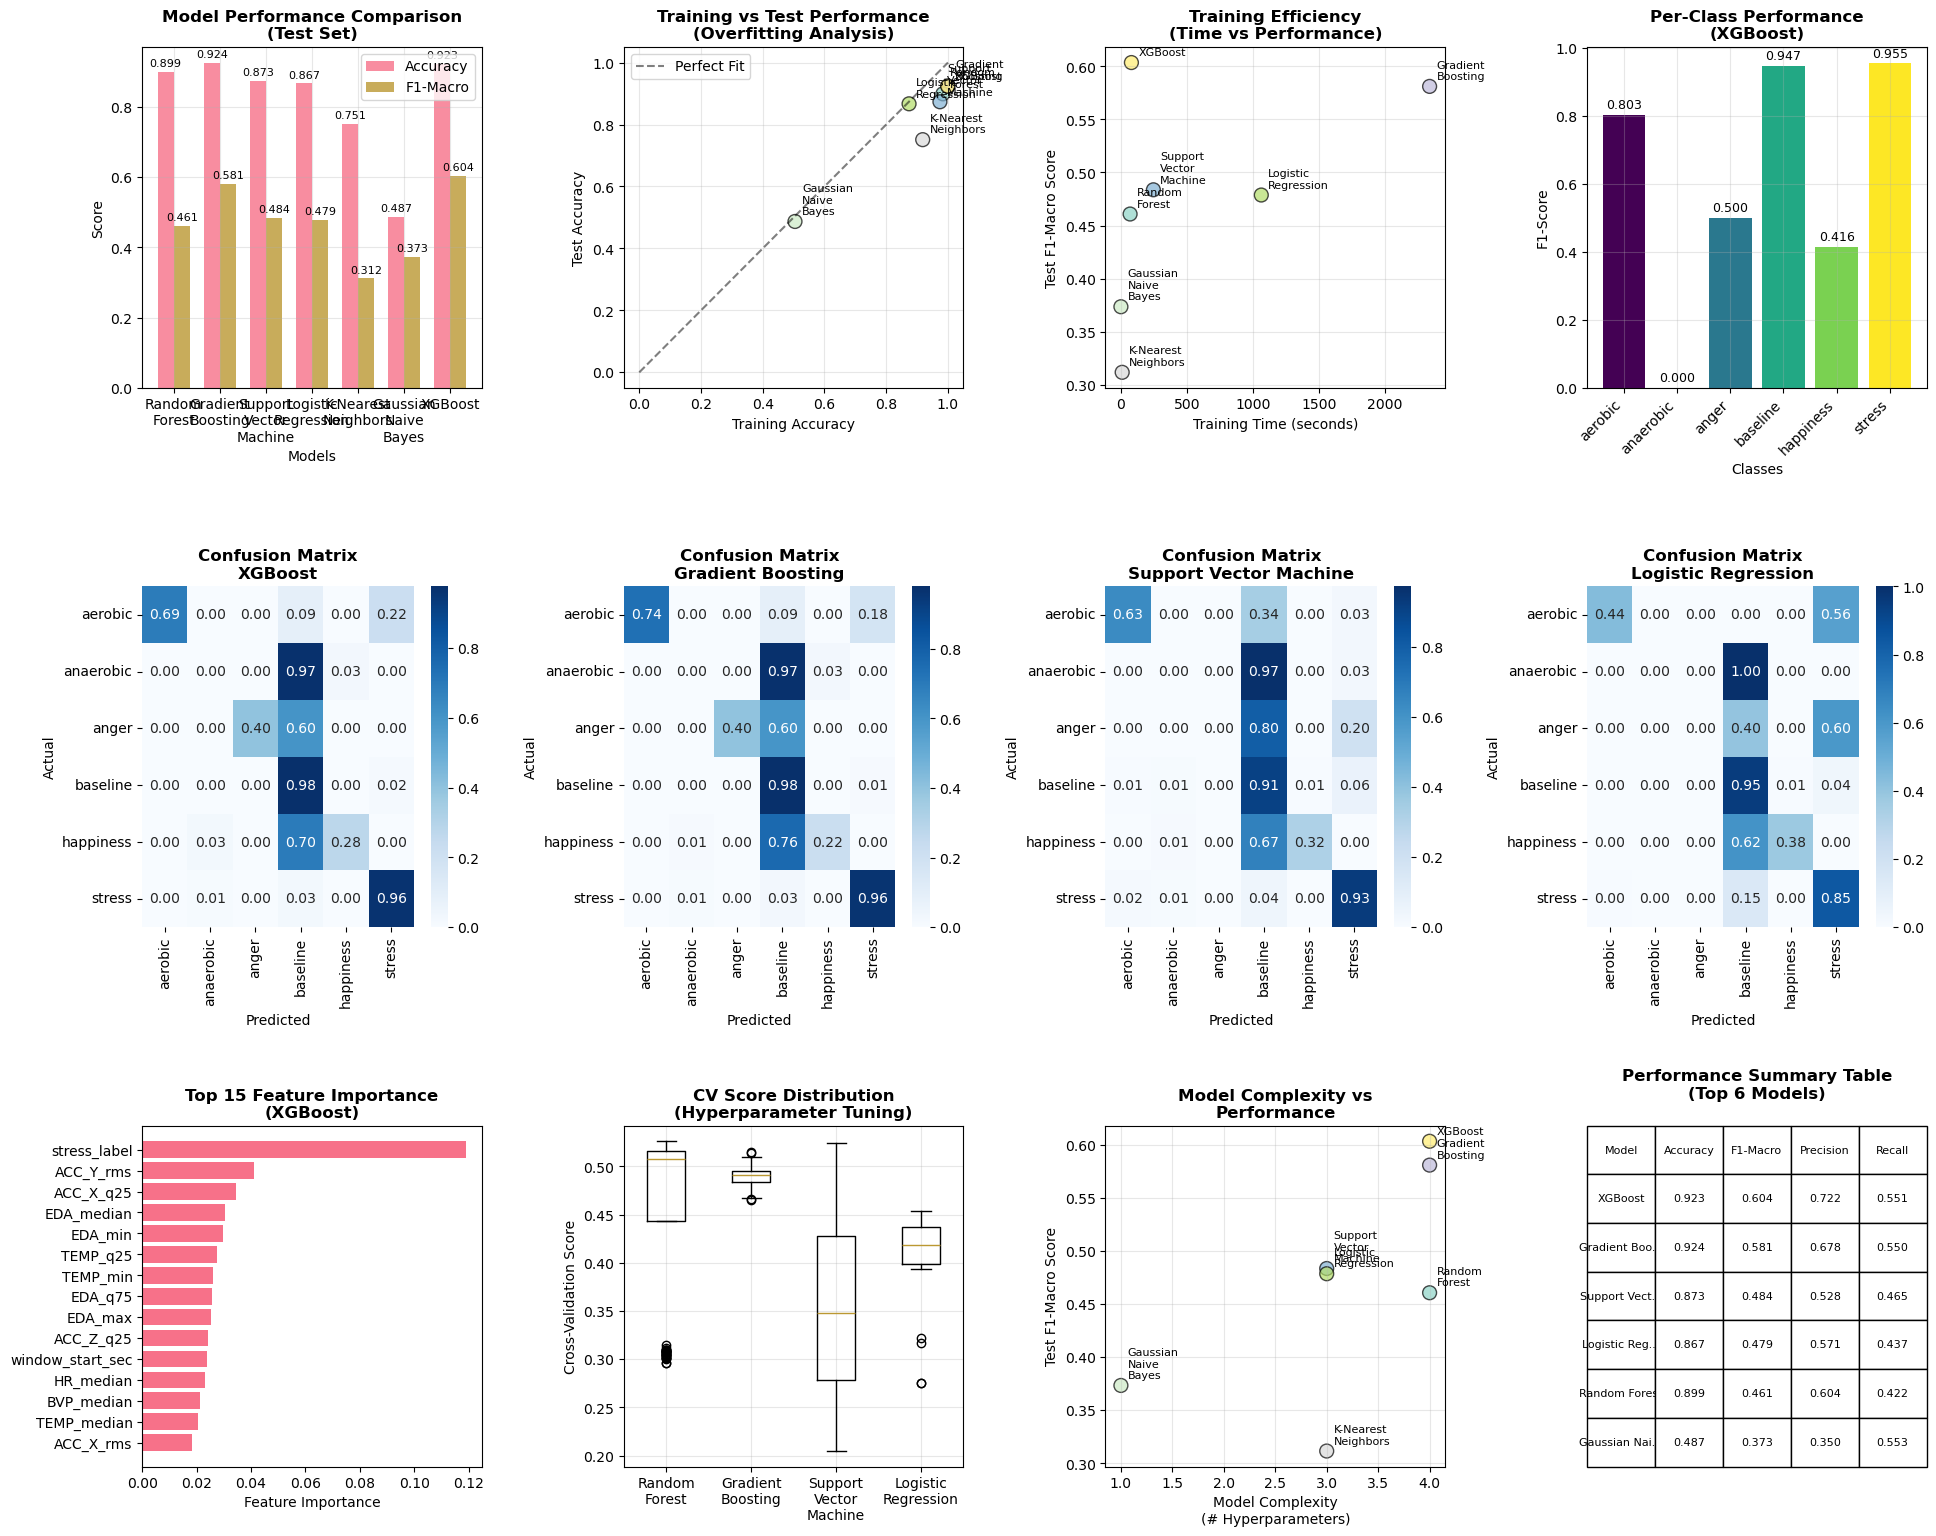

✓ All visualizations generated successfully!


In [12]:
# =============================================================================
# SECTION 8: PLOT TRAINING AND VALIDATION METRICS
# =============================================================================

print("="*80)
print("COMPREHENSIVE VISUALIZATION OF RESULTS")
print("="*80)

# Create comprehensive visualization plots
fig = plt.figure(figsize=(20, 16))

# Color palette for models
colors = plt.cm.Set3(np.linspace(0, 1, len(evaluation_results)))
model_colors = {name: colors[i] for i, name in enumerate(evaluation_results.keys())}

# 1. Model Performance Comparison - Bar Chart
plt.subplot(3, 4, 1)
models_list = list(evaluation_results.keys())
test_accuracies = [evaluation_results[model]['testing']['accuracy'] for model in models_list]
test_f1_scores = [evaluation_results[model]['testing']['f1_macro'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

bars1 = plt.bar(x - width/2, test_accuracies, width, label='Accuracy', alpha=0.8)
bars2 = plt.bar(x + width/2, test_f1_scores, width, label='F1-Macro', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison\n(Test Set)', fontweight='bold')
plt.xticks(x, [model.replace(' ', '\n') for model in models_list], rotation=0, ha='center')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Training vs Test Performance
plt.subplot(3, 4, 2)
train_accuracies = [evaluation_results[model]['training']['accuracy'] for model in models_list]
test_accuracies = [evaluation_results[model]['testing']['accuracy'] for model in models_list]

plt.scatter(train_accuracies, test_accuracies, c=[model_colors[model] for model in models_list], 
           s=100, alpha=0.7, edgecolors='black', linewidth=1)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Fit')
plt.xlabel('Training Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Training vs Test Performance\n(Overfitting Analysis)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add model labels
for i, model in enumerate(models_list):
    plt.annotate(model.replace(' ', '\n'), (train_accuracies[i], test_accuracies[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')

# 3. Training Time vs Performance
plt.subplot(3, 4, 3)
training_times = [trained_models[model]['training_time'] for model in models_list]
performance_scores = test_f1_scores

plt.scatter(training_times, performance_scores, c=[model_colors[model] for model in models_list],
           s=100, alpha=0.7, edgecolors='black', linewidth=1)
plt.xlabel('Training Time (seconds)')
plt.ylabel('Test F1-Macro Score')
plt.title('Training Efficiency\n(Time vs Performance)', fontweight='bold')
plt.grid(True, alpha=0.3)

for i, model in enumerate(models_list):
    plt.annotate(model.replace(' ', '\n'), (training_times[i], performance_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')

# 4. Per-Class F1 Scores for Best Model
plt.subplot(3, 4, 4)
best_model = results['best_model']
best_f1_scores = evaluation_results[best_model]['testing']['f1_per_class']
class_names = le.classes_

bars = plt.bar(class_names, best_f1_scores, color=plt.cm.viridis(np.linspace(0, 1, len(class_names))))
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title(f'Per-Class Performance\n({best_model})', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels
for bar, score in zip(bars, best_f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# 5-8. Confusion Matrices for Top 4 Models
top_4_models = performance_comparison[:4]
for i, model_info in enumerate(top_4_models):
    plt.subplot(3, 4, 5 + i)
    model_name = model_info['Model']
    cm = np.array(evaluation_results[model_name]['confusion_matrix']['testing'])
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix\n{model_name}', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# 9. Feature Importance (if available)
plt.subplot(3, 4, 9)
if hasattr(trained_models[best_model]['best_model'], 'feature_importances_'):
    importances = trained_models[best_model]['best_model'].feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15 features
    
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance\n({best_model})', fontweight='bold')
    plt.gca().invert_yaxis()
elif hasattr(trained_models[best_model]['best_model'], 'coef_'):
    # For linear models, use coefficient magnitudes
    coef = np.abs(trained_models[best_model]['best_model'].coef_).mean(axis=0)
    indices = np.argsort(coef)[::-1][:15]
    
    plt.barh(range(len(indices)), coef[indices])
    plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
    plt.xlabel('Coefficient Magnitude')
    plt.title(f'Top 15 Feature Coefficients\n({best_model})', fontweight='bold')
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, f'Feature importance\nnot available for\n{best_model}', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Feature Importance\nNot Available', fontweight='bold')

# 10. Cross-Validation Scores Distribution
plt.subplot(3, 4, 10)
cv_scores_data = []
cv_labels = []

for model_name in models_list[:4]:  # Top 4 models only
    if 'grid_search' in trained_models[model_name]:
        grid_search = trained_models[model_name]['grid_search']
        # Get test scores from cross-validation
        test_scores = grid_search.cv_results_['mean_test_score']
        cv_scores_data.append(test_scores)
        cv_labels.append(model_name.replace(' ', '\n'))

if cv_scores_data:
    plt.boxplot(cv_scores_data, labels=cv_labels)
    plt.ylabel('Cross-Validation Score')
    plt.title('CV Score Distribution\n(Hyperparameter Tuning)', fontweight='bold')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)

# 11. Model Complexity vs Performance
plt.subplot(3, 4, 11)
# Create a simple complexity metric based on number of parameters tuned
complexity_scores = []
for model_name in models_list:
    n_params = len(models[model_name]['param_grid'])
    complexity_scores.append(n_params)

plt.scatter(complexity_scores, test_f1_scores, c=[model_colors[model] for model in models_list],
           s=100, alpha=0.7, edgecolors='black', linewidth=1)
plt.xlabel('Model Complexity\n(# Hyperparameters)')
plt.ylabel('Test F1-Macro Score')
plt.title('Model Complexity vs\nPerformance', fontweight='bold')
plt.grid(True, alpha=0.3)

for i, model in enumerate(models_list):
    plt.annotate(model.replace(' ', '\n'), (complexity_scores[i], test_f1_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')

# 12. Performance Summary Table (as text plot)
plt.subplot(3, 4, 12)
plt.axis('off')
table_data = []
headers = ['Model', 'Accuracy', 'F1-Macro', 'Precision', 'Recall']

for model_info in performance_comparison[:6]:  # Top 6 models
    row = [
        model_info['Model'][:12] + '...' if len(model_info['Model']) > 15 else model_info['Model'],
        f"{model_info['Test_Accuracy']:.3f}",
        f"{model_info['Test_F1_Macro']:.3f}",
        f"{model_info['Test_Precision_Macro']:.3f}",
        f"{model_info['Test_Recall_Macro']:.3f}"
    ]
    table_data.append(row)

table = plt.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
plt.title('Performance Summary Table\n(Top 6 Models)', fontweight='bold', pad=20)

plt.tight_layout(pad=3.0)

# Save the comprehensive plot
plot_path = RESULTS_PATH / 'plots' / 'comprehensive_model_evaluation.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Comprehensive visualization saved to: {plot_path}")

plt.show()

print("✓ All visualizations generated successfully!")

In [13]:
# =============================================================================
# SECTION 9: SAVE TRAINED MODELS AND FINAL RESULTS
# =============================================================================

print("="*80)
print("SAVING TRAINED MODELS AND GENERATING FINAL REPORT")
print("="*80)

# Save the best performing model
best_model_name = results['best_model']
best_model_obj = trained_models[best_model_name]['best_model']
best_model_path = MODELS_PATH / 'best_model' / 'final_best_model.pkl'

with open(best_model_path, 'wb') as f:
    pickle.dump(best_model_obj, f)

print(f"✓ Best model ({best_model_name}) saved to: {best_model_path}")

# Save all trained models
all_models_path = MODELS_PATH / 'all_trained_models.pkl'
all_models_dict = {name: info['best_model'] for name, info in trained_models.items()}

with open(all_models_path, 'wb') as f:
    pickle.dump(all_models_dict, f)

print(f"✓ All trained models saved to: {all_models_path}")

# Create comprehensive final report
final_report = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'dataset_shape': df.shape,
        'n_features': len(feature_cols),
        'n_classes': len(le.classes_),
        'class_names': le.classes_.tolist(),
        'train_test_split': {
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'split_strategy': 'subject-aware' if 'subject_id' in df.columns else 'stratified'
        }
    },
    
    'model_performance': {
        'best_model': {
            'name': best_model_name,
            'test_accuracy': evaluation_results[best_model_name]['testing']['accuracy'],
            'test_f1_macro': evaluation_results[best_model_name]['testing']['f1_macro'],
            'test_precision_macro': evaluation_results[best_model_name]['testing']['precision_macro'],
            'test_recall_macro': evaluation_results[best_model_name]['testing']['recall_macro'],
            'training_time_seconds': trained_models[best_model_name]['training_time'],
            'best_parameters': trained_models[best_model_name]['best_params']
        },
        
        'all_models_summary': performance_comparison,
        
        'per_class_performance': {
            'class_names': le.classes_.tolist(),
            'best_model_f1_scores': evaluation_results[best_model_name]['testing']['f1_per_class'],
            'best_model_precision_scores': evaluation_results[best_model_name]['testing']['precision_per_class'],
            'best_model_recall_scores': evaluation_results[best_model_name]['testing']['recall_per_class']
        }
    },
    
    'feature_analysis': {},
    
    'recommendations': {
        'production_model': best_model_name,
        'alternative_models': [model['Model'] for model in performance_comparison[1:3]],
        'overfitting_concerns': [
            model['Model'] for model in performance_comparison 
            if model.get('Overfitting', False)
        ],
        'fast_inference_models': [
            model['Model'] for model in performance_comparison 
            if model.get('Training_Time', float('inf')) < 10
        ]
    },
    
    'files_generated': {
        'best_model': str(best_model_path),
        'all_models': str(all_models_path),
        'preprocessing_objects': str(MODELS_PATH / 'preprocessing_objects.pkl'),
        'evaluation_results': str(RESULTS_PATH / 'model_evaluation_results.json'),
        'performance_comparison': str(RESULTS_PATH / 'performance_comparison.json'),
        'training_results': str(RESULTS_PATH / 'training_results.json'),
        'comprehensive_plot': str(RESULTS_PATH / 'plots' / 'comprehensive_model_evaluation.png')
    }
}

# Add feature importance if available
if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    feature_importance_dict = dict(zip(feature_cols, importances))
    # Get top 20 features
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    final_report['feature_analysis'] = {
        'method': 'feature_importances_',
        'top_20_features': sorted_features[:20]
    }
elif hasattr(best_model_obj, 'coef_'):
    coef_mean = np.abs(best_model_obj.coef_).mean(axis=0)
    feature_importance_dict = dict(zip(feature_cols, coef_mean))
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    final_report['feature_analysis'] = {
        'method': 'coefficient_magnitude',
        'top_20_features': sorted_features[:20]
    }

# Save final report
report_path = RESULTS_PATH / 'final_training_report.json'
with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2, default=str)

print(f"✓ Final report saved to: {report_path}")

# Generate summary statistics
print("\n" + "="*80)
print("FINAL TRAINING SUMMARY")
print("="*80)

print(f"📊 Dataset Statistics:")
print(f"   Total samples: {df.shape[0]:,}")
print(f"   Features used: {len(feature_cols)}")
print(f"   Classes: {len(le.classes_)} ({', '.join(le.classes_)})")
print(f"   Train/Test split: {len(X_train):,}/{len(X_test):,}")

print(f"\n🏆 Best Model Performance:")
best_metrics = final_report['model_performance']['best_model']
print(f"   Model: {best_metrics['name']}")
print(f"   Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   Test F1-Macro: {best_metrics['test_f1_macro']:.4f}")
print(f"   Test Precision-Macro: {best_metrics['test_precision_macro']:.4f}")
print(f"   Test Recall-Macro: {best_metrics['test_recall_macro']:.4f}")
print(f"   Training Time: {best_metrics['training_time_seconds']:.2f} seconds")

print(f"\n🔧 Best Hyperparameters:")
for param, value in best_metrics['best_parameters'].items():
    print(f"   {param}: {value}")

print(f"\n📈 Top 3 Performing Models:")
for i, model in enumerate(performance_comparison[:3], 1):
    print(f"   {i}. {model['Model']}: F1-Macro = {model['Test_F1_Macro']:.4f}")

if final_report['feature_analysis']:
    print(f"\n🎯 Top 5 Most Important Features:")
    for i, (feature, importance) in enumerate(final_report['feature_analysis']['top_20_features'][:5], 1):
        print(f"   {i}. {feature}: {importance:.4f}")

print(f"\n💾 Files Generated:")
for file_type, file_path in final_report['files_generated'].items():
    print(f"   {file_type}: {file_path}")

print(f"\n✅ Model training and validation completed successfully!")
print(f"✅ Best model ready for deployment: {best_model_name}")
print(f"✅ All results and models saved to: {MODELS_PATH} and {RESULTS_PATH}")

# Create a quick deployment guide
deployment_guide = f"""
# Model Deployment Guide

## Quick Start
```python
import pickle
import pandas as pd
import numpy as np

# Load the trained model and preprocessing objects
with open('{best_model_path}', 'rb') as f:
    model = pickle.load(f)

with open('{MODELS_PATH / 'preprocessing_objects.pkl'}', 'rb') as f:
    preprocessing = pickle.load(f)

# Load new data
# new_data = pd.read_csv('your_new_data.csv')

# Preprocess new data (with KNN imputation for missing values)
# X_new = new_data[preprocessing['feature_columns']]

# Apply KNN imputation if there are missing values
# if X_new.isnull().sum().sum() > 0 and preprocessing['knn_imputer'] is not None:
#     X_new_imputed = preprocessing['knn_imputer'].transform(X_new)
#     X_new = pd.DataFrame(X_new_imputed, columns=X_new.columns, index=X_new.index)

# Apply feature scaling
# X_new_scaled = preprocessing['feature_scaler'].transform(X_new)

# Make predictions
# predictions = model.predict(X_new_scaled)
# prediction_labels = preprocessing['label_encoder'].inverse_transform(predictions)

# Get prediction probabilities for confidence scores
# if hasattr(model, 'predict_proba'):
#     probabilities = model.predict_proba(X_new_scaled)
#     confidence_scores = np.max(probabilities, axis=1)
```

## Model Information
- Best Model: {best_model_name}
- Test Accuracy: {best_metrics['test_accuracy']:.4f}
- Test F1-Macro: {best_metrics['test_f1_macro']:.4f}
- Classes: {', '.join(le.classes_)}
- Data Imputation: KNN-based (creates fully rich feature profiles)

## Files Needed for Deployment
1. Model: {best_model_path}
2. Preprocessing: {MODELS_PATH / 'preprocessing_objects.pkl'}
3. Feature list: {len(feature_cols)} features
4. KNN Imputer: Included in preprocessing objects

## Subject Classification Pipeline
1. Load physiological data for subject
2. Apply KNN imputation for missing values (creates complete profile)
3. Scale features using trained scaler
4. Predict classification: baseline, stress, happiness, aerobic, anaerobic, anger
5. Return confidence scores for decision making

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

deployment_guide_path = RESULTS_PATH / 'deployment_guide.md'
with open(deployment_guide_path, 'w') as f:
    f.write(deployment_guide)

print(f"✅ Deployment guide saved to: {deployment_guide_path}")
print(f"\n🚀 Ready for production deployment!")

SAVING TRAINED MODELS AND GENERATING FINAL REPORT
✓ Best model (XGBoost) saved to: /home/alvaro-ibarra/smartwatch-stress-detection/models/trained_models/best_model/final_best_model.pkl
✓ All trained models saved to: /home/alvaro-ibarra/smartwatch-stress-detection/models/trained_models/all_trained_models.pkl
✓ Final report saved to: /home/alvaro-ibarra/smartwatch-stress-detection/results/final_training_report.json

FINAL TRAINING SUMMARY
📊 Dataset Statistics:
   Total samples: 10,387
   Features used: 109
   Classes: 6 (aerobic, anaerobic, anger, baseline, happiness, stress)
   Train/Test split: 7,474/2,298

🏆 Best Model Performance:
   Model: XGBoost
   Test Accuracy: 0.9234
   Test F1-Macro: 0.6036
   Test Precision-Macro: 0.7224
   Test Recall-Macro: 0.5509
   Training Time: 79.79 seconds

🔧 Best Hyperparameters:
   learning_rate: 0.2
   max_depth: 5
   n_estimators: 50
   subsample: 0.8

📈 Top 3 Performing Models:
   1. XGBoost: F1-Macro = 0.6036
   2. Gradient Boosting: F1-Macro = 